### Since Jupyter Lab was unavailable on https://portal.expanse.sdsc.edu/, I performed the assignment locally on my personal notebook using Spark.

<img src="error.png" width="3000" height="200" alt="이미지 설명">

In [12]:
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame 
from pyspark.sql.functions import col, to_timestamp,when, expr,avg
from pyspark.sql.types import *
import pandas as pd
from tabulate import tabulate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Data Load
spark = SparkSession.builder \
    .appName("NYC_Analysis") \
    .getOrCreate()

df_combined = spark.read.parquet(
    "fhvhv_tripdata_2019-02.parquet",
    "fhvhv_tripdata_2019-03.parquet",
    "fhvhv_tripdata_2019-04.parquet",
    "fhvhv_tripdata_2019-05.parquet",
    "fhvhv_tripdata_2019-06.parquet",
)

1.File size

In [3]:
# 1.File size
#My local notebook couldn't handle the larger dataset efficiently due to performance bottlenecks, so I used this dataset for the assignment."
import os

file_sizes = [os.path.getsize(f) for f in [
    "fhvhv_tripdata_2019-02.parquet",
    "fhvhv_tripdata_2019-03.parquet",
    "fhvhv_tripdata_2019-04.parquet",
    "fhvhv_tripdata_2019-05.parquet",
    "fhvhv_tripdata_2019-06.parquet",
]]
total_size = sum(file_sizes)

print(f"Total file size: {total_size:,} bytes (~{total_size / (1024 ** 3):.2f} GB)")

Total file size: 2,790,578,768 bytes (~2.60 GB)


2.Print Schema

In [4]:
# 1.Print Schema
df_combined.printSchema() 

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- originating_base_num: string (nullable = true)
 |-- request_datetime: timestamp_ntz (nullable = true)
 |-- on_scene_datetime: timestamp_ntz (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: string (nullable = true)
 |-- shared_match_flag: string (nullable = true)
 |-- access_a_ride_

3.print total columns, rows

In [5]:
#print total rows
print(f"Total Columns: {len(df_combined.columns)}")
print(f"Total Rows: {df_combined.count()}") 

Total Columns: 24
Total Rows: 109089759


4.Print Data table

In [6]:
df_combined.show(3, truncate=False) 

+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+----+----------+-------------------+-----------------+------------------+----------------+--------------+
|hvfhs_license_num|dispatching_base_num|originating_base_num|request_datetime   |on_scene_datetime  |pickup_datetime    |dropoff_datetime   |PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls|bcf |sales_tax|congestion_surcharge|airport_fee|tips|driver_pay|shared_request_flag|shared_match_flag|access_a_ride_flag|wav_request_flag|wav_match_flag|
+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+--

5.Map license numbers to service names

In [7]:
df_combined = df_combined.withColumn(
    "service_name",
    when(col("hvfhs_license_num") == "HV0002", "Juno")
    .when(col("hvfhs_license_num") == "HV0003", "Uber")
    .when(col("hvfhs_license_num") == "HV0004", "Via")
    .when(col("hvfhs_license_num") == "HV0005", "Lyft")
    .otherwise("Unknown")  
)
df_combined.select("hvfhs_license_num", "service_name").show(3, truncate=False)

+-----------------+------------+
|hvfhs_license_num|service_name|
+-----------------+------------+
|HV0003           |Uber        |
|HV0003           |Uber        |
|HV0005           |Lyft        |
+-----------------+------------+
only showing top 3 rows



6.Number of Trips per Service Provider

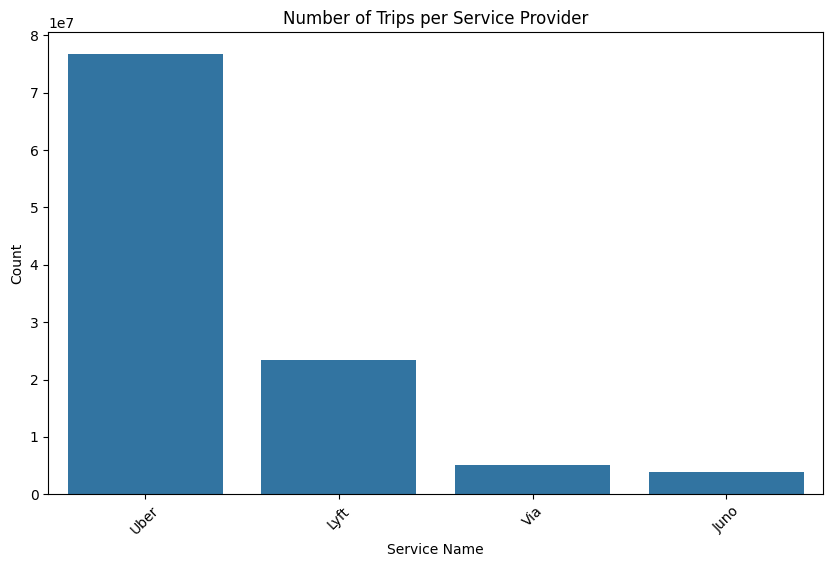

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert PySpark DataFrame to Pandas
df_pandas = df_combined.groupBy(["hvfhs_license_num", "service_name"]).count().toPandas()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="service_name", y="count", data=df_pandas)

# Improve readability
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.xlabel("Service Name")
plt.ylabel("Count")
plt.title("Number of Trips per Service Provider")

# Show the plot
plt.show()

7.Creating delay_time(Min) column by subtracting request_datetime from pickup_datetime

In [9]:
df_combined = df_combined.withColumn("delay_time_minutes", (col("pickup_datetime") - col("request_datetime")).cast("long") / 60)

8.Calculate mean (average) and median of delay(mins)

In [15]:
mean_delay = df_combined.select(avg("delay_time_minutes")).collect()[0][0]
median_delay = df_combined.approxQuantile("delay_time_minutes", [0.5], 0.01)[0]

print(f"Mean delay time: {mean_delay:.2f} mins")
print(f"Median delay time: {median_delay:.2f} mins")

Mean delay time: 5.10 mins
Median delay time: 4.30 mins


9. Calculate median delay time per service_name

In [17]:
mean_delay_df = df_combined.groupBy("service_name").agg(avg("delay_time_minutes").alias("mean_delay"))

median_delay_df = df_combined.groupBy("service_name").agg(
    expr("percentile_approx(delay_time_minutes, 0.5)").alias("median_delay"))

print("-----------------Mean---------------")
mean_delay_df.show()
print("-----------------Median---------------")
median_delay_df.show()


-----------------Mean---------------
+------------+------------------+
|service_name|        mean_delay|
+------------+------------------+
|        Lyft| 4.827334797295607|
|         Via|  8.54001919891759|
|        Juno|5.4139613653061005|
|        Uber| 4.950232395021037|
+------------+------------------+

-----------------Median---------------
+------------+-----------------+
|service_name|     median_delay|
+------------+-----------------+
|        Lyft|              4.1|
|         Via|7.766666666666667|
|        Juno|              4.9|
|        Uber|4.166666666666667|
+------------+-----------------+



In [27]:
df_combined

ConnectionRefusedError: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다